#Arctic freshwater analysis

This is the notebook that I used to calculate freshwater content and investgate its relation with AO. Bascally I found nothing by using ECMWF's ORAS4 dataset and I don't want to do more.  

In [1]:
import glob
import scipy.io
import datetime
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
% matplotlib inline

In [2]:
RB=[0.25, 0.41, 0.88]    # Royal blue
AM=[0.90, 0.17, 0.31]    # Amathran
CamB = [0.64, 0.76, 0.68]# Cambridge blue

$$
FWC = \int^{0}_{z_{lim}}{\left( 1-\frac{S(z)}{S_{ref}} \right)dz}
$$

* $S_{ref}$ is 34.8 as the end-member of Atlantic water
* $S(z)$ is the salinity profile as a function of $z$
* $z_{lim}$ first level of $S\left(z_{lim}\right) \geq S_{ref}$

In [3]:
def fwc_1d(S, z, Sref):
    if S[0] < Sref:
        id_lim = np.min(np.searchsorted(S, Sref, 'left'))
        fun = 1-S[:id_lim]/Sref
        return np.trapz(fun, x=z[:id_lim])
    else:
        return np.nan
def fwc_2d(S, z, Sref):
    fwc = np.empty(S.shape)[0, :, :]
    for i in range(np.size(S, 1)):
        for j in range(np.size(S, 2)):
            fwc[i, j] = fwc_1d(S[:, i, j], z, Sref)
    return fwc

# A test: WOA 1996 - 2005 climatology

In [6]:
JJA_name=glob.glob('../../_data/Reanalysis/WOA/*s13*.nc')
DJF_name=glob.glob('../../_data/Reanalysis/WOA/*s15*.nc')

In [8]:
JJA_obj=nc.Dataset(JJA_name[0])
DJF_obj=nc.Dataset(DJF_name[0])
print('Variables in {}:\n==============================================\n{}'.format(JJA_name[0], JJA_obj.variables.keys()))

In [8]:
lon=JJA_obj.variables['lon'][:]
lat=JJA_obj.variables['lat'][:]
JJA=JJA_obj.variables['s_an'][:]
DJF=DJF_obj.variables['s_an'][:]
depth=JJA_obj.variables['depth'][:]
longitude, latitude = np.meshgrid(lon, lat)

In [29]:
longitude.shape

(180L, 360L)

In [25]:
fwc_JJA = fwc_2d(JJA[0, :, :, :], depth, 34.8)
fwc_DJF = fwc_2d(DJF[0, :, :, :], depth, 34.8)

In [26]:
fwc_JJA_mask = np.ma.masked_where(np.isnan(fwc_JJA), fwc_JJA)
fwc_DJF_mask = np.ma.masked_where(np.isnan(fwc_DJF), fwc_DJF)

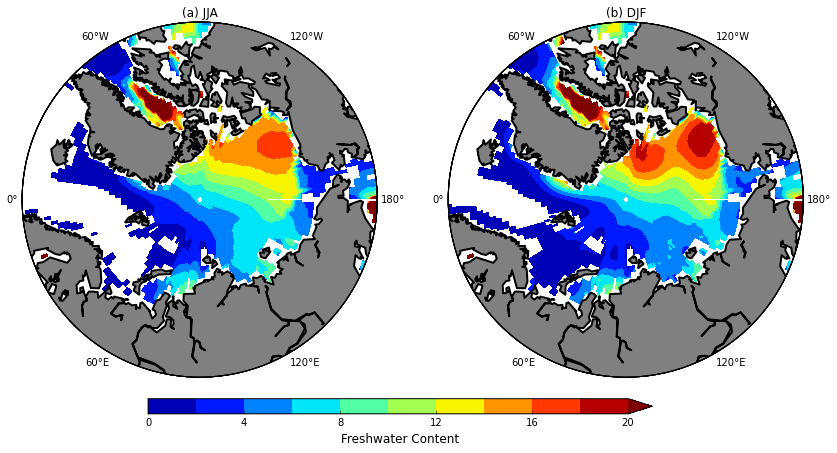

In [28]:
fig = plt.figure(figsize=(14, 14))
ax1 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)

proj=Basemap(projection='npstere', resolution='c', boundinglat=60, lon_0=90, round=True, ax=ax1)
proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
proj.drawcoastlines(linewidth=2.0, linestyle='-', color='k')
x, y=proj(longitude, latitude)
CS = proj.contourf(x, y, fwc_JJA_mask, range(0, 22, 2), extend='max')
ax1.set_title('(a) JJA')

ax = fig.gca()
proj=Basemap(projection='npstere', resolution='c', boundinglat=60, lon_0=90, round=True, ax=ax2)
proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
proj.drawcoastlines(linewidth=2.0, linestyle='-', color='k')
x, y=proj(longitude, latitude)
CS = proj.contourf(x, y, fwc_DJF_mask, range(0, 22, 2), extend='max')
ax2.set_title('(b) DJF')

cax  = fig.add_axes([0.25, 0.3, 0.5, 0.015])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('Freshwater Content (m)', fontsize=12)

# Calculation based on ANHA4 salinity

In [4]:
SName = sorted(glob.glob('../../_data/MAT files/vosaline_by_month/vosaline*mat'))

In [5]:
dep_name = '/ocean/yingkai/GEOTRACES/NEMO-CODE/NEMOGCM/CONFIG/ANHA4_OFF/EXP00/mesh_zgr.nc'
dep_obj = nc.Dataset(dep_name)
deptht = dep_obj.variables['nav_lev'][:]

# MY_TRC domain
MAT = scipy.io.loadmat('../../_data/Exchange/Ba_boundary_ANHA4.mat')
domain = MAT['domain'][:].T

In [8]:
FWC = np.zeros([800, 544])
FWC[FWC==0]=np.nan
print('allocation done')

# Loops
for time in range(144):
    vosaline = scipy.io.loadmat(SName[time])['vosaline'][:]
    for i in range(800):
        for j in range(544):
            if(domain[i, j]!=0):
                #print('Catch: {}, {}'.format(i, j))
                FWC[i, j] = fwc_1d(vosaline[:31, i, j], deptht[:31], Sref=34.8)
                # Save
    save_var = { 'FWC': FWC}
    scipy.io.savemat('../../_data/MAT files/FWC/FWC_ANHA4_ALL'+str(time)+'.mat', mdict=save_var)
    print('Calculating {}'.format(time))


allocation done
Calculating 0
Calculating 1
Calculating 2
Calculating 3
Calculating 4
Calculating 5
Calculating 6
Calculating 7
Calculating 8
Calculating 9
Calculating 10
Calculating 11
Calculating 12
Calculating 13
Calculating 14
Calculating 15
Calculating 16
Calculating 17
Calculating 18
Calculating 19
Calculating 20
Calculating 21
Calculating 22
Calculating 23
Calculating 24
Calculating 25
Calculating 26
Calculating 27
Calculating 28
Calculating 29
Calculating 30
Calculating 31
Calculating 32
Calculating 33
Calculating 34
Calculating 35
Calculating 36
Calculating 37
Calculating 38
Calculating 39
Calculating 40
Calculating 41
Calculating 42
Calculating 43
Calculating 44
Calculating 45
Calculating 46
Calculating 47
Calculating 48
Calculating 49
Calculating 50
Calculating 51
Calculating 52
Calculating 53
Calculating 54
Calculating 55
Calculating 56
Calculating 57
Calculating 58
Calculating 59
Calculating 60
Calculating 61
Calculating 62
Calculating 63
Calculating 64
Calculating 65
Calc